In [1]:
#https://ipyton.org/ipython-docdex/config/extsions/autoreload.html
%reload_ext autoreload
%autoreload 2

#version information
%reload_ext version_information
%version_information Cython, matplotlib, numpy, pandas,  qutip, seaborn, scipy, sklearn, tqdm, version_information,

Software versions
Python 3.6.4 64bit [GCC 7.2.0]
IPython 6.3.1
OS Linux 4.9.87 linuxkit aufs x86_64 with debian stretch sid
Cython 0.28.2
matplotlib 2.1.2
numpy 1.13.3
pandas 0.22.0
qutip The 'qutip' distribution was not found and is required by the application
seaborn 0.8.1
scipy 1.0.1
sklearn 0.19.1
tqdm 4.23.4
version_information 1.0.3
Fri Jun 08 09:11:59 2018 UTC

We are interested in understanding a influencer, Donald Trump in this case. We have looked at his sentiment. Now, we will look at topics that unsupervised learning can pull out of Trump's tweets. First we apply Gensim Latent Dirichlet Allocation (LDA) algorithm. 

The process is to convert all the tweets from Trump into a Bag of Words. This uses the word multiplicity of each word in Trump's Tweets. It represents each tweet as one vector in a question-answer pair. Answering "How often does the word occur in the tweet?" 

We then use this Bag of Words to construct a corpus to train vector transformations on. We train a TF-IDF followed by a Latent Dirichlet Allocation transformation. 

Term Frequency which stands for Inverse Document Frequency, converts a bag-of-words vector space (the corpus) to another vector space of the same dimensionality, except that features which were rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact.

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA’s topics can be interpreted as probability distributions over words. These distributions are inferred automatically the  training corpus. Tweets are in turn interpreted as a (soft) mixture of these topics.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
from six.moves import range
from tqdm import tqdm

#some packages for cleaning and wrangling
from collections import defaultdict
import datetime as dt
import re
from tqdm import tqdm

#some packages for natural language processing
import nltk

#some pacakages for working with sentiment
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from nltk.classify import NaiveBayesClassifier
import spacy


from __future__ import print_function

#Only for use in Python 2.6.0a2 and later
from __future__ import print_function
#from nltk.sentiment.util import *
#from nltk.corpus import opinion_lexicon
#from nltk.tokenize import treebank

#some packages for gensim and topic 
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from itertools import chain
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
import os
from gensim import corpora
import logging
from collections import defaultdict
from gensim import corpora, models, similarities


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

print(nltk.__version__)

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


3.3


In [3]:
#downlaod some lexicons from nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#need to download a new tagger 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
sid = SentimentIntensityAnalyzer()


#Only for use in Python 2.6.0a2 and later
from __future__ import print_function




Pull in the work from the previous notebook "sentiment". 

In [5]:
%store -r trump_sentiment
trump_sentiment.head(1)

index         username              date  retweets  favorites  \
0      0  realDonaldTrump  2018-05-24 14:18     14051      64210   

                                                text  geo  \
0  Today, it was my great honor to present the #M...  NaN   

              mentions       hashtags                  id  \
0  @USNavy @WhiteHouse  #MedalOfHonor  999761589476655105   

              ...                       timestamp sentiment_vader_trump_18  \
0             ...             2018-05-24 14:18:00                   0.8316   

                               cnn_text_before_tweet  \
0  [A University of Southern California faculty o...   

   cnn_sentiment_before_tweet  \
0                    0.021307   

                               nbc_text_before_tweet  \
0  [House Democrats are inviting Parkland student...   

   nbc_sentiment_before_tweet  \
0                    0.114326   

                               nyt_text_before_tweet  \
0  [André Leon Talley: I wish fashion was an easi...   

   nyt_sentiment_before_tweet  \
0                   -0.018259   

                               fox_text_before_tweet  \
0  [Marie Harf on NFL kneeling policy: It doesn't...   

   fox_sentiment_before_tweet  
0                    -0.00054  

[1 rows x 22 columns]

In [6]:
trump_18 = trump_sentiment.copy()
trump_18.head(1)

index         username              date  retweets  favorites  \
0      0  realDonaldTrump  2018-05-24 14:18     14051      64210   

                                                text  geo  \
0  Today, it was my great honor to present the #M...  NaN   

              mentions       hashtags                  id  \
0  @USNavy @WhiteHouse  #MedalOfHonor  999761589476655105   

              ...                       timestamp sentiment_vader_trump_18  \
0             ...             2018-05-24 14:18:00                   0.8316   

                               cnn_text_before_tweet  \
0  [A University of Southern California faculty o...   

   cnn_sentiment_before_tweet  \
0                    0.021307   

                               nbc_text_before_tweet  \
0  [House Democrats are inviting Parkland student...   

   nbc_sentiment_before_tweet  \
0                    0.114326   

                               nyt_text_before_tweet  \
0  [André Leon Talley: I wish fashion was an easi...   

   nyt_sentiment_before_tweet  \
0                   -0.018259   

                               fox_text_before_tweet  \
0  [Marie Harf on NFL kneeling policy: It doesn't...   

   fox_sentiment_before_tweet  
0                    -0.00054  

[1 rows x 22 columns]

We will need to do some more cleaning to remove twitter and web syntax.

In [7]:
def clean_tweets_inplace(dataframe , column_name):
    """creats new column in dataframe with cleaned tweets
    provide dataframe to clean and column text text is in """
    dataframe['clean_tweet']= None
    l=len(dataframe)
    for i in tqdm( range(l) ):
        
        clean_tweet = dataframe[column_name][i].lower()
        clean_tweet = re.sub( r"http.?://[^\s]+[\s]?" , "" , clean_tweet )
        clean_tweet = re.sub( r"@[^\s]+[\s]?", "" , clean_tweet )
        clean_tweet = re.sub( r"[\W'-]+", " " , clean_tweet )
        clean_tweet = re.sub( r"[0-9]", "" , clean_tweet )
        dataframe['clean_tweet'].iloc[i]= clean_tweet
    

In [8]:
# Remove everthing but words 
clean_tweets_inplace( trump_18 , "trump_18_tweet" )

  0%|          | 0/2415 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 2415/2415 [02:52<00:00, 13.99it/s]


In [9]:
trump_18.head(1)

index         username              date  retweets  favorites  \
0      0  realDonaldTrump  2018-05-24 14:18     14051      64210   

                                                text  geo  \
0  Today, it was my great honor to present the #M...  NaN   

              mentions       hashtags                  id  \
0  @USNavy @WhiteHouse  #MedalOfHonor  999761589476655105   

                         ...                         sentiment_vader_trump_18  \
0                        ...                                           0.8316   

                               cnn_text_before_tweet  \
0  [A University of Southern California faculty o...   

  cnn_sentiment_before_tweet  \
0                   0.021307   

                               nbc_text_before_tweet  \
0  [House Democrats are inviting Parkland student...   

  nbc_sentiment_before_tweet  \
0                   0.114326   

                               nyt_text_before_tweet  \
0  [André Leon Talley: I wish fashion was an easi...   

  nyt_sentiment_before_tweet  \
0                  -0.018259   

                               fox_text_before_tweet  \
0  [Marie Harf on NFL kneeling policy: It doesn't...   

  fox_sentiment_before_tweet  \
0                   -0.00054   

                                         clean_tweet  
0  today it was my great honor to present the med...  

[1 rows x 23 columns]

In [10]:
# load in stop words for english
stop_words = set( nltk.corpus.stopwords.words("english") )

#add extra terms to remove from tokens
extra_stop= ['com', 'twitter', 'pic', 'u', 'http', 'wh', 'many','must',"gov","w","g","#","nd"]
for i in extra_stop:
    stop_words.add(i)

In [11]:
#function to tokenize tweets
def token_lem_stop_tweets_col(dataframe):
    """creats new column in dataframe with tokenized, and lemmatized words 
    excluding stop word (not intentional left in)"""
    wnl = WordNetLemmatizer()
  
    #create new columns in dataframe
    dataframe['token_tweet']=None
    dataframe['lemmatized_tweet']=None
    
    #loop over dataframe and tokenize/lemmatize
    l=len(dataframe)
    for i in tqdm ( range(l) ):
        token_tweets= nltk.word_tokenize( dataframe.clean_tweet[i] )#nltk function to tokenize 
        token_stop = [ token for token in token_tweets if not token in stop_words ]#remove stop words for english
        dataframe.token_tweet.iloc[i] = token_stop #add to column
        lemmed_tokens= [wnl.lemmatize(token) for token in token_stop] #take tokenize and lemmatize
        lemmed_stop = [ token for token in lemmed_tokens if not token in stop_words ]
        dataframe.lemmatized_tweet.iloc[i] = lemmed_stop #add to column

In [12]:
#tokenize and lemmatize tweets
token_lem_stop_tweets_col( trump_18 )

  0%|          | 0/2415 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 2415/2415 [08:18<00:00,  4.84it/s]


In [13]:
#make a list of lists for each word token in each tweet
nest_list_tweet_tokens = [i for i in trump_18['lemmatized_tweet']]

Gensim maps each document (tweet in our case) as a vector. Each vector is a representation of "How many times a word appears in the text?" ("document word question") matched to the count in document. Gensim calls this mapping between the questions and ids a dictionary:

In [14]:
#map each integer id to "document word question" as dictionary
dictionary = Dictionary(nest_list_tweet_tokens)

dictionary.save('trump_18.dict')

print(dictionary)

Dictionary(6008 unique tokens: ['britt', 'ceremony', 'chief', 'east', 'full']...)


The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector. 

In [15]:
#make a bag of words: convert tokenized tweets to vectors
corpus_lda = [dictionary.doc2bow(text) for text in nest_list_tweet_tokens]
# store to disk, save time later
mm = corpora.MmCorpus.serialize('trump_18.dict', corpus_lda)  

In [16]:
print(mm)

None


Next we transform the corpus into a vector space. Transformations always convert between two specific vector spaces. TfIdf, the “training” consists simply of going through the supplied corpus once and computing document frequencies of all its features. We will chain this with LDA later to use that vector space.

### TF_IDF vectorization

In [17]:
#convert corpus to vector space
tfidf = models.TfidfModel(corpus_lda)
tfidf

## Designate number of topics here for LDA

Gensim LDA transformer requires the bag of words corpus, the dictionary, and the number of topics. We will start with 10. The problem of picking the best topic number is similar to trying to pick the right number of clusters in unsupervised clustering. The most common techniques in clustering is the elbow method, the silhouette, and the gap. We will explore some of these techniques later in trying to optimize the LDA model.

From the source documents and a little research Gensim additional parameters are:

Passes: The number of passes and iterations is the number of loops through the corpus. The greater the number of passes, the more accurate the model will be.

Alpha and eta are hyper-parameters that affect sparsity of the document-topic and topic-word distributions.

Alpha ‘auto’ learns an asymmetric prior directly from the data.

ETA ‘auto’ learns an asymmetric prior over words directly from your data.

Alpha contributes to how smooth the model is. A small alpha makes each document more specific (fewer topics). A big alpha allows topics to cross pollinate (tweets can be in multiple topics). When alpha is to big then tweets appear into to many topics.

In [18]:
#chain model for use with lda model in ginsum, must supply number of topics here
# initialize an Lda transformation
%time lda = models.LdaModel(corpus_lda, id2word=dictionary, num_topics=10, passes=20, iterations = 400, alpha='auto', eta='auto',eval_every=None , random_state=42)



CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


Now use this to transform any tweet (or word) into our vector space of trump tweets. We see that the result is the probability of the tweet relating to one of our topics. We can use this to tag tweet by topic

In [19]:
new_tweet = trump_18.token_tweet[0]
vec_bow = dictionary.doc2bow(new_tweet)#convert tweet to bag of words 
print('vec_bow', vec_bow,"\n")
vec_lda = lda[vec_bow] # convert the query to LDA space
print("vec_lda", vec_lda)

vec_bow [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)] 

vec_lda [(4, 0.78090864), (6, 0.1977368)]


## What are the topics? 
We can see that too. Recall this is based on frequency of words per tweet to infer the hidden structure of topics. We see that the words are grouped into topic by the lda model. 

Show topics shows num_topics, and the vocabulary_size array of floats. This array represents the term topic matrix learned during inference.

In [20]:
#show all ten topics
lda.show_topics()

[(0,
  '0.020*"great" + 0.011*"president" + 0.011*"thank" + 0.008*"honor" + 0.008*"thought" + 0.007*"prayer" + 0.007*"france" + 0.007*"melania" + 0.006*"paris" + 0.005*"people"'),
 (1,
  '0.011*"news" + 0.010*"fake" + 0.010*"great" + 0.009*"people" + 0.009*"thank" + 0.007*"join" + 0.007*"medium" + 0.007*"trump" + 0.006*"usa" + 0.006*"live"'),
 (2,
  '0.015*"hillary" + 0.014*"great" + 0.013*"job" + 0.013*"clinton" + 0.009*"america" + 0.008*"crooked" + 0.008*"comey" + 0.007*"fbi" + 0.007*"state" + 0.007*"dollar"'),
 (3,
  '0.012*"great" + 0.009*"election" + 0.009*"president" + 0.009*"news" + 0.008*"fake" + 0.008*"thank" + 0.007*"trump" + 0.007*"russian" + 0.006*"big" + 0.006*"thing"'),
 (4,
  '0.024*"great" + 0.024*"republican" + 0.020*"tax" + 0.016*"america" + 0.015*"cut" + 0.014*"healthcare" + 0.013*"obamacare" + 0.012*"vote" + 0.012*"senator" + 0.011*"democrat"'),
 (5,
  '0.022*"news" + 0.020*"fake" + 0.013*"great" + 0.012*"story" + 0.012*"medium" + 0.012*"trump" + 0.011*"job" + 0.009

In [21]:
#look at topic 1
lda.show_topic(1)

[('news', 0.010796523),
 ('fake', 0.0099018821),
 ('great', 0.0097152563),
 ('people', 0.0093299448),
 ('thank', 0.0091616809),
 ('join', 0.0068283323),
 ('medium', 0.0066425395),
 ('trump', 0.0065073613),
 ('usa', 0.0058642626),
 ('live', 0.0056952196)]

How to read this. Look at topic 1 "trade", "great", "deal" etc are words that contribute to topic one. The other arrays show words that contribute to their topic. 

Some of the topics definitely cluster around human interpretable themes. We could title topic one as economic, or maybe market. Topic 4 seems to be dealing with the Russian election scandal. Other ones are less coherent, or more intermingled (that alpha and smoothness thing) like topic nine which could be military gratitude or tax legislation. 

Back to the number of topic questions. How can we estimate a good choose? Could we break topic nine into a separate topic ten or maybe combine it with topic zero into a gratitude topic? Recall, we randomly picked 10 topics to build the model. Is there a better way? Lets try some techniques from clustering. 

### Picking a better Topic number

We will jump to Sklearn to do this. We will first need to convert the Gensim corpus to a matrix. Gensim provides the tools in 'matutils'. We will use cosine similarity. Cosine similarity uses the direction vectors are pointing as the measure of similarity. It disregards, well cares less about, the magnitude. This is what we want words that point at the same topic. It does this by looking at the angle between them. A small angle means pointing at the same thing. Orthogonal, at 90 degrees, has angle zero. In the opposite directions the measure is negative.

In [25]:
#get a consine using word2vec 
from gensim.models import Word2Vec
#initialize a model with the list of list of tokens from before
word2vec= Word2Vec( nest_list_tweet_tokens, size=100, window=10, min_count=1, workers=4, seed=42)
#get cosine similarity matrix as sparse matrix for sklearn
csr_lda = word2vec.wv.similarity_matrix(dictionary, tfidf=tfidf) 
csr_lda

<6008x6008 sparse matrix of type '<class 'numpy.float32'>'
	with 500410 stored elements in Compressed Sparse Column format>


Now, clustering in Sklearn. We started with 2 to 50 topics using the elbow method. We check the plot to see if there is a bend. The elbow method uses sum-of squares to find the distance from the centroid. The bend is the point where the sum-of-squares reduces more slowly and hence not worth the computation.


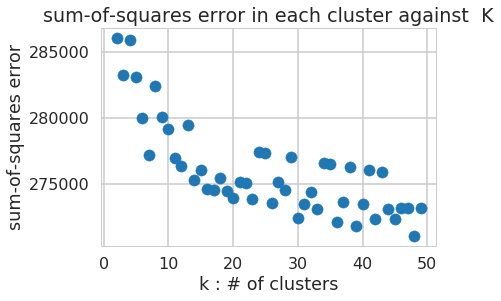

In [26]:
#import cluster model KMeans
from sklearn.cluster import KMeans

#ranges to test for cluster
k_range=[i for i in range(2,50)]

#list to hold sum-of-squares error
ss=[]

#loop over cluster values to find sum-of-squares error
for k in k_range:
    model=KMeans(n_clusters=k ,random_state=42)
    
    #fit KMeans on matrix with out customer names
    model.fit(csr_lda)
    
    #add sum-of-squares error to appropriate list
    ss.append(model.inertia_)
    
#Construct a plot showing  SS for each  K
plt.scatter(k_range,ss)
_ = plt.xlabel('k : # of clusters')
_ = plt.ylabel('sum-of-squares error')
_ = plt.title('sum-of-squares error in each cluster against  K')

plt.savefig('50_clusters.png')

plt.show()

Not bad. Right around 10 the linear trend take over. Lets look closer and plot 2 to 12. 

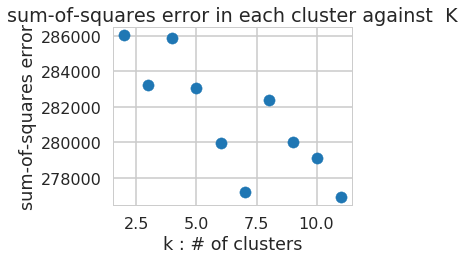

In [30]:
#import cluster model KMeans
from sklearn.cluster import KMeans

#ranges to test for cluster
k_range=[i for i in range(2,12)]

#list to hold sum-of-squares error
ss=[]

#loop over cluster values to find sum-of-squares error
for k in k_range:
    model=KMeans(n_clusters=k, random_state=42)
    
    #fit KMeans on matrix with out customer names
    model.fit(csr_lda)
    
    #add sum-of-squares error to appropriate list
    ss.append(model.inertia_)
    
#Construct a plot showing  SS for each  K
plt.scatter(k_range,ss)
_ = plt.xlabel('k : # of clusters')
_ = plt.ylabel('sum-of-squares error')
_ = plt.title('sum-of-squares error in each cluster against  K')
#to prevent saving from cutting edges
plt.tight_layout()
#save and show figure for paper
plt.savefig('10_clusters.png')
plt.show()

Ten and 4 seem to be reasonable choices from the elbow method. Lets try one last method the silhouette and see if we get agreement. The silhouette score measures how well a cluster is formed. It does this by comparing the distance of each point to the cluster it is in and then to other clusters. We want well defined separated clusters and not ones where data points could be in either. The silhouette score tries to capture this.

A good score is above .75, a bad one below .25, .75-.5 decent, and .5-.25 is weak.


In [29]:
#import metrics for sihouette score
from sklearn import metrics

cluster_range = [2,3,4,5,6,7,8,9,10]
best_cluster=None #capture best cluster in loop
best_score =0 #capture best score in loop
#loop over cluser range
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42) #kmeans instance
    kmeans.fit(csr_lda) #fit
 
    labels = kmeans.labels_ #get labels
    centroids = kmeans.cluster_centers_ #get centroids
 
    silhouette_score = metrics.silhouette_score(csr_lda, labels, metric='euclidean', random_state=42) #score
    
    #print score for cluster
    print ("Cluster {} Silhouette_score: ".format(i),silhouette_score,'\n')
    
    #update best cluster and best score
    if best_score<silhouette_score:
        best_score= silhouette_score
        best_cluster= i
print("Best cluster is {} with a score of {}.".format( best_cluster , best_score ) )

Cluster 2 Silhouette_score:  0.0908829 

Cluster 3 Silhouette_score:  0.0769435 

Cluster 4 Silhouette_score:  0.00403347 

Cluster 5 Silhouette_score:  0.0659804 

Cluster 6 Silhouette_score:  0.0745481 

Cluster 7 Silhouette_score:  -0.00340643 

Cluster 8 Silhouette_score:  -0.00845856 

Cluster 9 Silhouette_score:  -0.0102075 

Cluster 10 Silhouette_score:  -0.0132116 

Best cluster is 2 with a score of 0.09088291972875595.


The visual elbow got us pretty close. Now lets go back to the LDA model and try the new topic numbers. 

In [31]:
# initialize an Lda transformation with three topics and give a new name
%time lda_2 = models.LdaModel(corpus_lda, id2word=dictionary, num_topics=2, passes=20, iterations = 400, alpha='auto', eta='auto',eval_every=None , random_state=42)

CPU times: user 12.3 s, sys: 50 ms, total: 12.3 s
Wall time: 12.3 s


In [33]:
#show all ten topics
lda_2.show_topics()

[(0,
  '0.019*"great" + 0.008*"america" + 0.007*"people" + 0.007*"republican" + 0.006*"president" + 0.006*"thank" + 0.006*"job" + 0.006*"tax" + 0.005*"today" + 0.005*"year"'),
 (1,
  '0.012*"great" + 0.009*"news" + 0.008*"fake" + 0.008*"people" + 0.007*"job" + 0.006*"country" + 0.006*"time" + 0.005*"trump" + 0.005*"american" + 0.005*"year"')]

These topics look much less interpretable. Lets use a cool package pyLDAavis to explore both the 3 and 10 option. Recall that the elbow method said 4 was good but ten was the beginning of the linear trend.  

In [32]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_2, corpus_lda, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

If viewing in GitHub here is a picture of pyLDAvis display. (In case it does not load.)

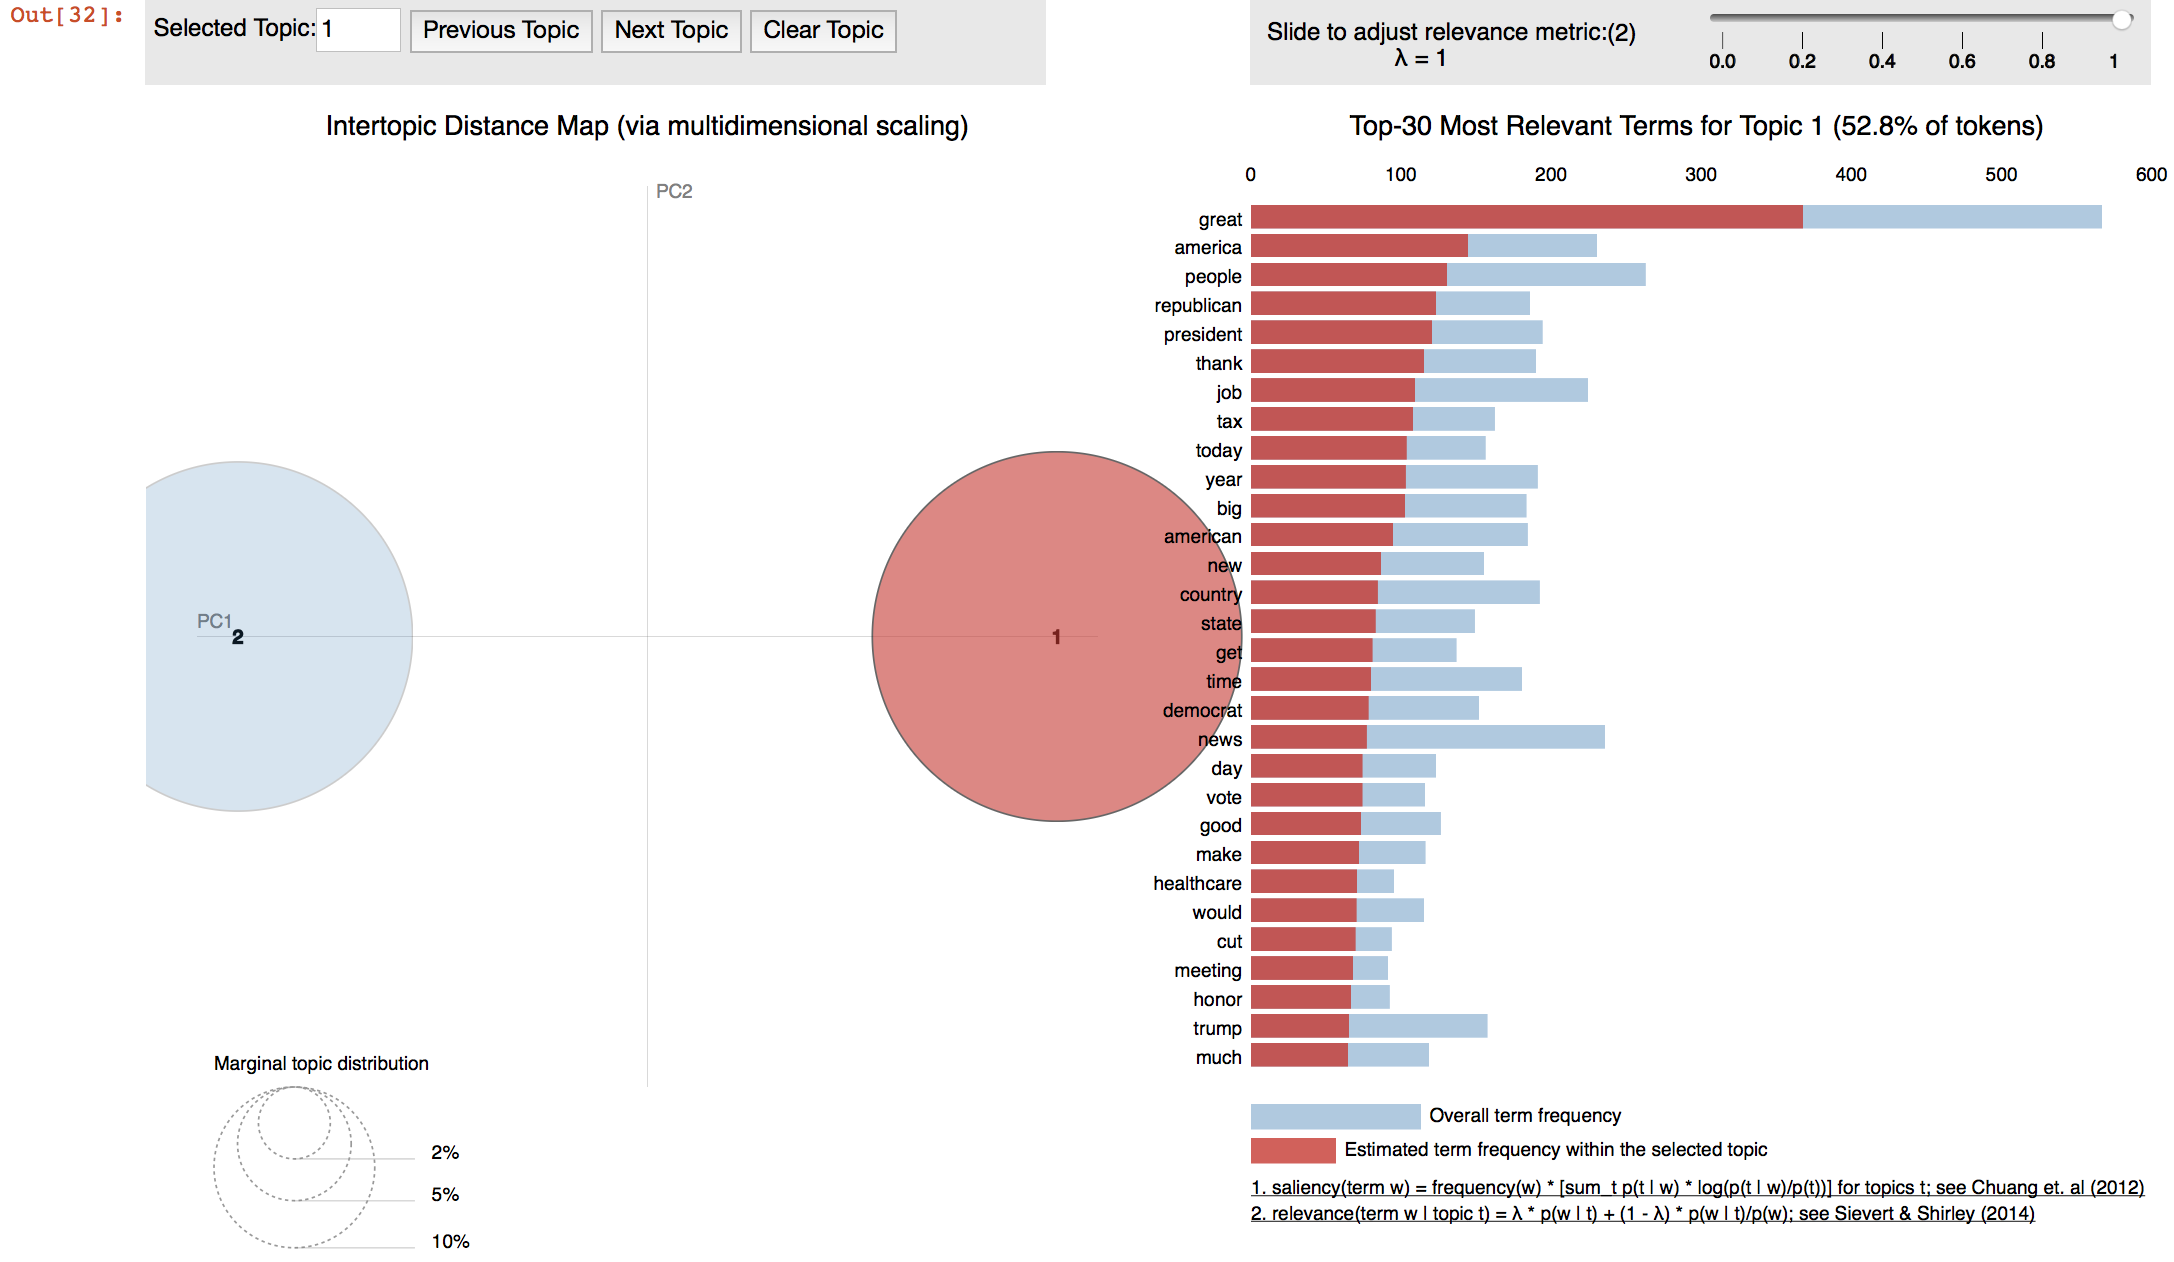

In [34]:
Image(filename='pics/pylda_2.png') 

In [35]:
#now lets look at the ten topics
lda_display = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

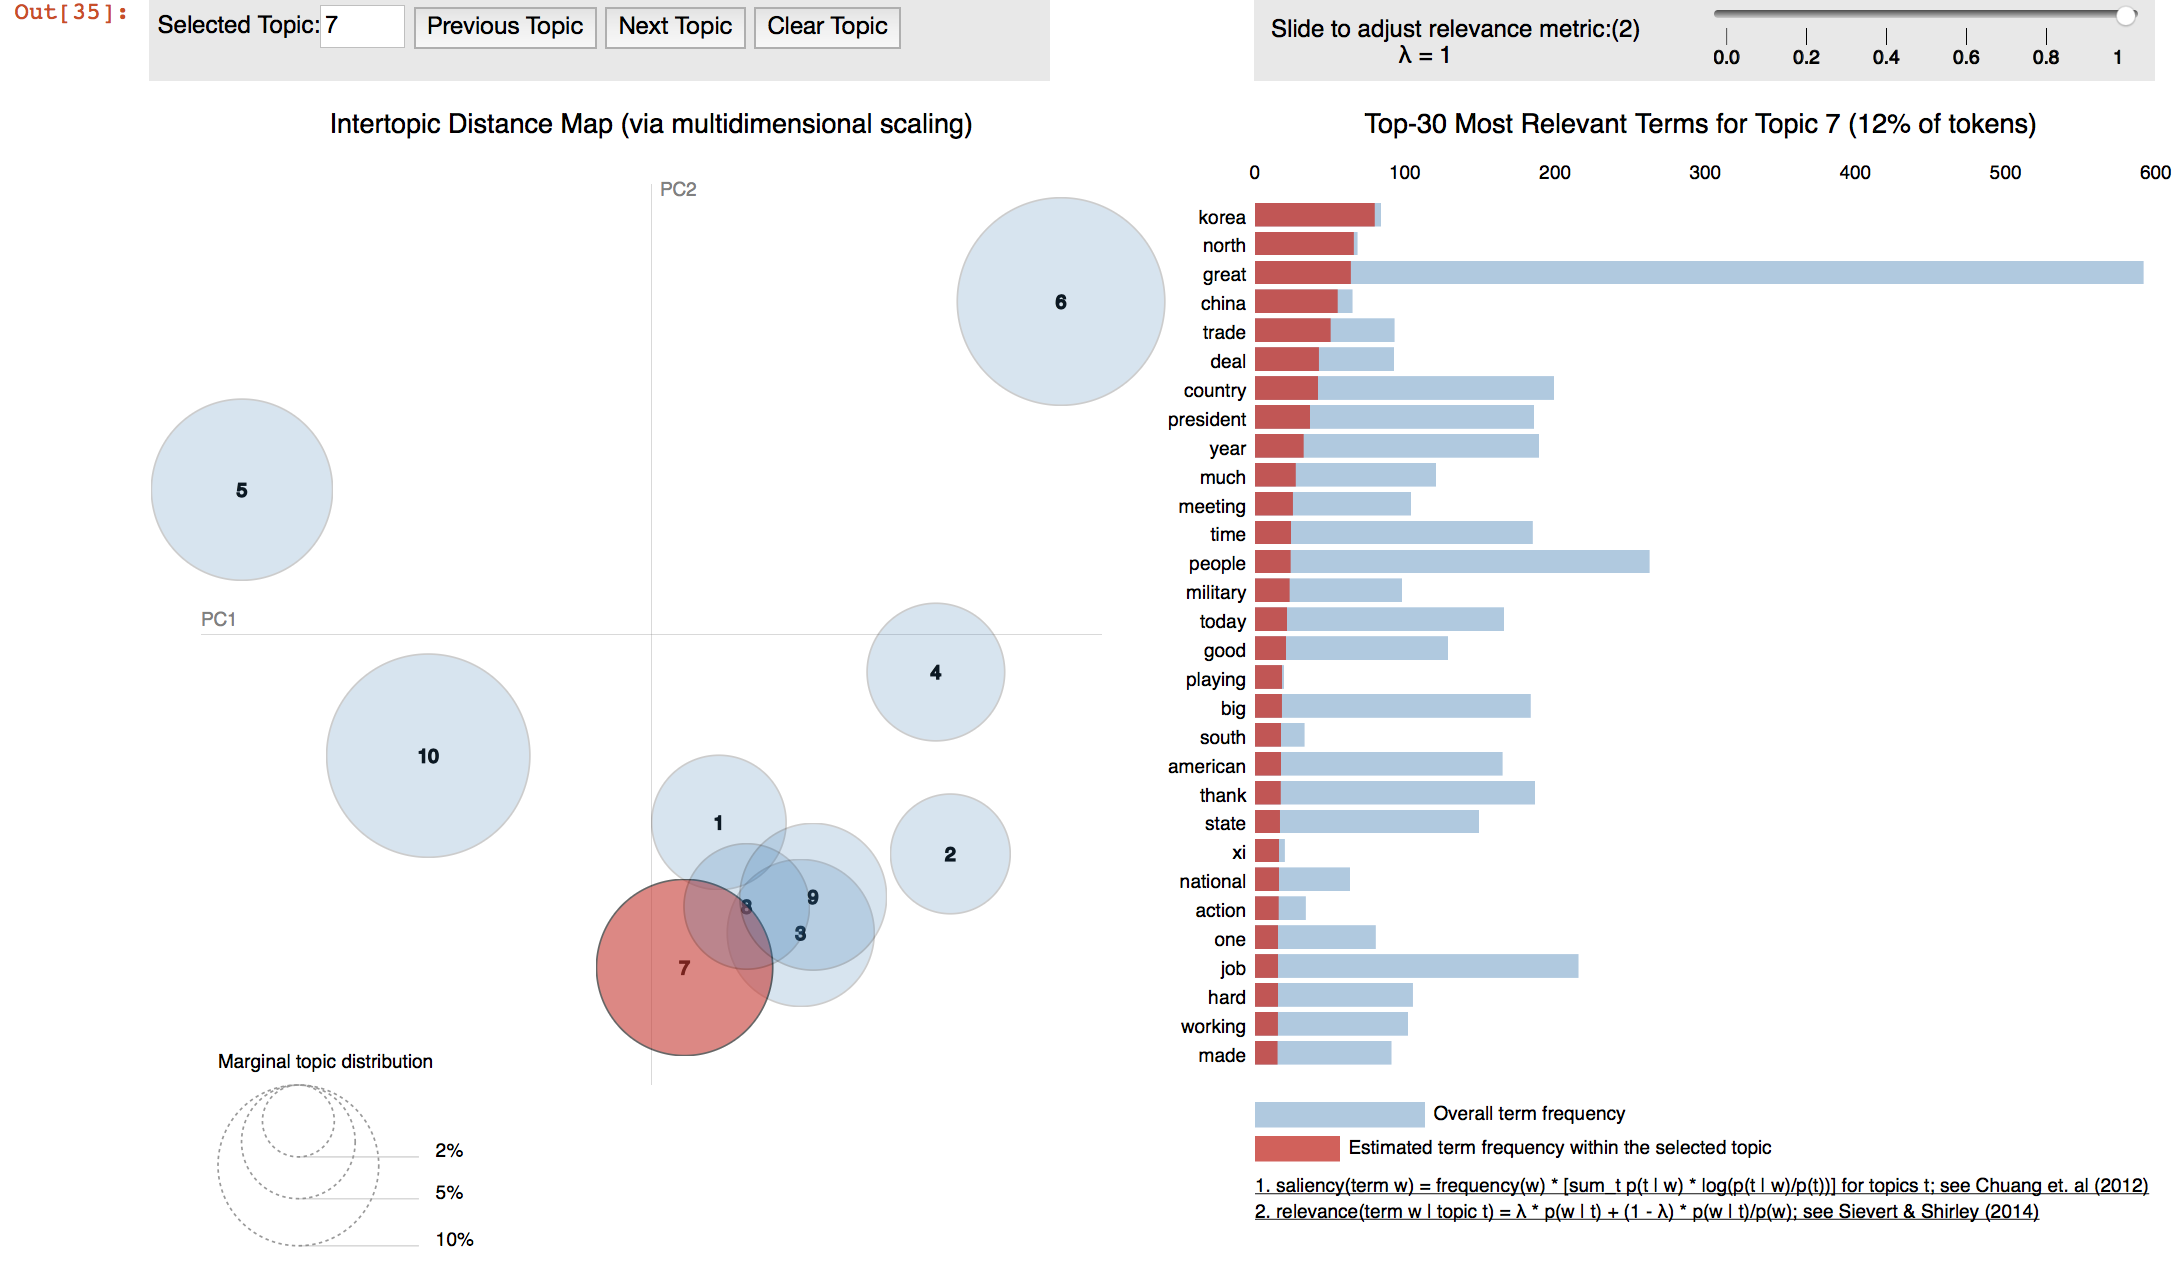

In [38]:
Image(filename='pics/pylda_10.png') 

## We see from the cool PCA visualization why the silhouette method preferred 2 over 10 topics. The clusters are nice and separated and very distinct. However, the elbow method gives us a more human interpretable answer for topic inference.

We are building this for humans so we choose ten topics. Next, we tag each Trump tweet with its topic and visualize it.

In [40]:
def tweet_topic_lda(dataframe , token_tweet_col, name_of_source):
    """ use LDA to extract tweet topic 
    provide dataframe , column with tweet tokenized , and name tweet source"""
 
    #create column name
    column_name='{}_topic_lda'.format(name_of_source)
    dataframe[column_name]=None
    
    #loop starting at index one on trump dataframe and stopping before last index
    for i in tqdm( range ( len ( dataframe ) ) ): 
        
        #get tweet list of tokens
        get_topic= dataframe[token_tweet_col][i]
        #convert tweet to bag of words
        vec_bow = dictionary.doc2bow(get_topic)
        # convert the query to LDA space
        vec_lda = lda[vec_bow] 
        #set topic initial score to zero
        max_topic_score=0
        #loop over topcis tweet is about (max is lda space of topics)
        for j in range( len(vec_lda) ) :
            #check second tuple element if bigger designate new topic for tweet 
            if vec_lda[j][1]>max_topic_score:
                topic_lda_tweet=vec_lda[j][0]
                max_topic_score= vec_lda[j][1]
                
            #save main topic to dataframe column    
            dataframe.at[i, column_name] = topic_lda_tweet
            
        

In [41]:
#call function to tag each tweet by topic
tweet_topic_lda( trump_18 , "lemmatized_tweet", 'trump')
trump_18.head(1)

100%|██████████| 2415/2415 [00:00<00:00, 3741.63it/s]


index         username              date  retweets  favorites  \
0      0  realDonaldTrump  2018-05-24 14:18     14051      64210   

                                                text  geo  \
0  Today, it was my great honor to present the #M...  NaN   

              mentions       hashtags                  id       ...         \
0  @USNavy @WhiteHouse  #MedalOfHonor  999761589476655105       ...          

                               nbc_text_before_tweet  \
0  [House Democrats are inviting Parkland student...   

  nbc_sentiment_before_tweet  \
0                   0.114326   

                               nyt_text_before_tweet  \
0  [André Leon Talley: I wish fashion was an easi...   

   nyt_sentiment_before_tweet  \
0                   -0.018259   

                               fox_text_before_tweet  \
0  [Marie Harf on NFL kneeling policy: It doesn't...   

   fox_sentiment_before_tweet  \
0                    -0.00054   

                                         clean_tweet  \
0  today it was my great honor to present the med...   

                                         token_tweet  \
0  [today, great, honor, present, medalofhonor, s...   

                                    lemmatized_tweet  trump_topic_lda  
0  [today, great, honor, present, medalofhonor, s...                4  

[1 rows x 26 columns]

Now lets explore these topics visually

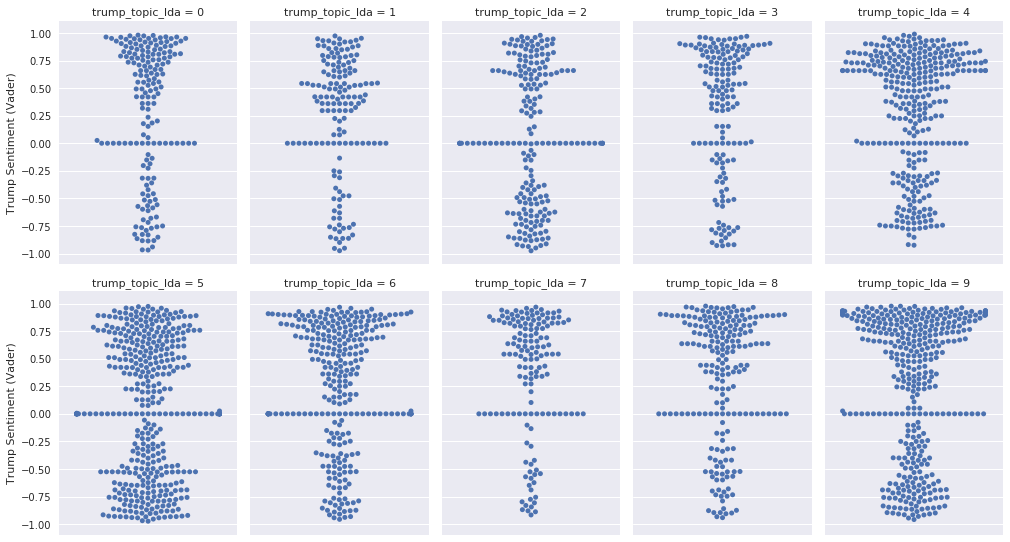

In [42]:
#using seaborn
sns.set()
#plot swamplots in five columns with vetical orientation
t_plots= sns.factorplot(x= "sentiment_vader_trump_18",\
               data= trump_18 , kind="swarm", orient='v' ,\
               col="trump_topic_lda",size=4, aspect=.7,col_wrap=5,);
#add label to scale
t_plots.set_axis_labels("", "Trump Sentiment (Vader)")

plt.savefig('swarmplot_topics.png')

We get a nice look at how Trump's Sentiment towards this topics. We see that topic 9, 4, and 6 seem to be pretty positive when trump talks about these. Topics 5, and maybe 2 seem to be slightly negative.

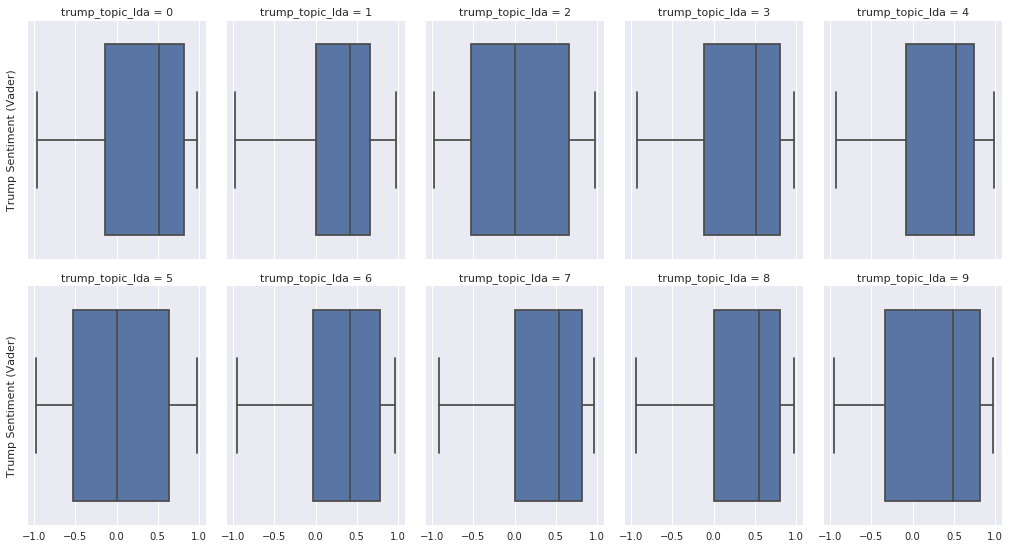

In [43]:
sns.set()
b_plots= sns.factorplot(x= "sentiment_vader_trump_18",\
               data= trump_18 , kind="box", orient='h' ,\
               col="trump_topic_lda",size=4, aspect=.7,col_wrap=5,);
#add label to scale
b_plots.set_axis_labels("", "Trump Sentiment (Vader)")

plt.savefig('boxplot_topics.png')

Looking at the box plot we get a much better feel for the quantitative side. Topic 5 and topic 2 are actually right near neutral.
One last plot to help explore these tweets. Lets jump back to Bokeh.

Two last plots to help explore these tweets. Lets jump back to Bokeh. 

In [44]:
#save topics for plotting
topic_0= trump_18[trump_18['trump_topic_lda']==0]
topic_1= trump_18[trump_18['trump_topic_lda']==1]
topic_2= trump_18[trump_18['trump_topic_lda']==2]
topic_3= trump_18[trump_18['trump_topic_lda']==3]
topic_4= trump_18[trump_18['trump_topic_lda']==4]
topic_5= trump_18[trump_18['trump_topic_lda']==5]
topic_6= trump_18[trump_18['trump_topic_lda']==6]
topic_7= trump_18[trump_18['trump_topic_lda']==7]
topic_8= trump_18[trump_18['trump_topic_lda']==8]
topic_9= trump_18[trump_18['trump_topic_lda']==9]

In [45]:
#make an interactive topics graph
import pandas as pd
from bokeh.layouts import gridplot, row , column 
from bokeh.models.widgets import Div
from bokeh.palettes import Set3,Spectral
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.io import show
from bokeh.models import HoverTool
from bokeh.layouts import gridplot
from bokeh.models import (
    ColumnDataSource,
    ColorBar,
    LinearColorMapper,
    LogColorMapper,
)
output_notebook()

source = ColumnDataSource(data={
    'timestamp'      : trump_18.timestamp,
    'sentiment vader trump 2018' : trump_18.sentiment_vader_trump_18,
    'trump_18_tweet'    : trump_18.trump_18_tweet,
})



t = figure(plot_width=1000, plot_height=350, x_axis_type="datetime")
t.title.text = '(Click on legend entries to mute the corresponding lines)'

t.circle( topic_0['timestamp'], topic_0['sentiment_vader_trump_18'], line_width=2, color='#5e4fa2', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_0')
t.circle( topic_1['timestamp'], topic_1['sentiment_vader_trump_18'], line_width=2, color='#3288bd', alpha=0.7,
           muted_color='beige', muted_alpha=0.2,  legend='topic_1')
t.circle( topic_2['timestamp'], topic_2['sentiment_vader_trump_18'], line_width=2, color='#66c2a5', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_2')
t.circle( topic_3['timestamp'], topic_3['sentiment_vader_trump_18'], line_width=2, color='#33FF7D', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_3')
t.circle( topic_4['timestamp'], topic_4['sentiment_vader_trump_18'], line_width=2, color="#67EE0F", alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_4')
t.circle( topic_5['timestamp'], topic_5['sentiment_vader_trump_18'], line_width=2, color='#fee08b', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_5')
t.circle( topic_6['timestamp'], topic_6['sentiment_vader_trump_18'], line_width=2, color='#fdae61', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_6')
t.circle( topic_7['timestamp'], topic_7['sentiment_vader_trump_18'], line_width=2, color='#f46d43', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_7')
t.circle( topic_8['timestamp'], topic_8['sentiment_vader_trump_18'], line_width=2, color='#d53e4f', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_8')
t.circle( topic_9['timestamp'], topic_9['sentiment_vader_trump_18'], line_width=2, color='#9e0142', alpha=0.7,
           muted_color='#deebf7', muted_alpha=0.2,  legend='topic_9')

t.legend.location = "top_left"
t.legend.click_policy="mute"


show(column(Div(text='<h2>Topic Sentiments for Trump')))

show(t)

Loading BokehJS ...

In [46]:
Image(filename='pics/t_topic_3.png') 

## A interactive topics graph.

(Click on the legend names to toggle topics to a muted version. Zoom in to a interesting time period. Pan around. Compare topics. Explore!)

We have built another cool tool, which we can add to a decision maker's or executive dashboard. At this point, we have two cool interactive graphs which help understand an influencer. 

Next steps, we could explore these topics in the news tweets. We could use the Gensim LDA algorithm to classify which tweet fit best into which topic. In the future, I would also incorporate "named entity recognition" to tag tweets and explore sentiment based off named entities.